<a href="https://colab.research.google.com/github/Rohitbachchhe17/rohitbachchhe/blob/main/Titanic_Prediction_with_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240315%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240315T064256Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc69af89c4d0632c2e4468665f68450ad8ea5b85e562ce8e2a36b2f0afaee65c98e9c2e09853fcae9ebd8cf90eb8fd7035a9ab08e29968e033a5a1df527f6fdbc8742c1995f0a7b55ea9b85a6443cee6d629dbd5bbd1843d6c13b44ab2372423910fbe4e8f69c0fa8d5a71837b608b5a75315ac1df771b3242b27b78c7a1fe75b59b19db489ce780825bdd5532b4e69703081bac0b771c36421352ba7e5f4d5a974c036fcc86c4216350187bd902d69f0301dcb86756c1d2f736ecaca86c908fd820654870ecd861e618799b7ad737838d824b0249e13ad8f02af1829941efc444021c576a8d2586a530e5c6e47b077df2a9cfffa96a6c9f41eabb5cd012b3456'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


Hello everyone!,

This is my first kernel on Kaggle.so any input is appreaciated. This notebook provides Exploratory analysis, feature engineering, data cleaning/mining and machine learning model parameter turning using GridSearchCV along with visualization of the decision boundaries the models.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import seaborn as sns
sns.set(context = 'paper', palette = 'winter_r', style = 'darkgrid', rc= {'figure.facecolor': 'gray',}, font_scale=1.5)

In [3]:
def Readcsv(data):
    return (pd.read_csv(data,index_col = 'PassengerId'))

traindf = Readcsv('../input/train.csv')
testdf  = Readcsv('../input/test.csv')

In [4]:
traindf.columns, testdf.columns

(Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
        'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
        'Cabin', 'Embarked'],
       dtype='object'))

There are many columns(features) in this dataset let us break them down.

**Survived**: Wheather the person Survived or not.

**Pclass**: Passanger class indicates the class of that person aboard the ship.

**SibSp**: Shows the number of Sibling/Spouces they had.

**Parch**: Parch indicates Parents with children

**TIcket**: Ticket name/Number.

**Fare**: How much the Passenger paid.

**Cabin**: Cabin name of that Passenger.

**Embarked**: Point of Embarkation where *C* means Cherbourg, *Q* means Queenstown, *S* means Southampton.

In [5]:
traindf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can differentiate the data into two groups:

**Categorical**: From the dataset we can see that *Survived*, *Pclass*, *Sex*, *Embarked* are categorical. Why? they have discrete values such has 0 or 1.

**Continuous**: From the dataset we can see that *Age* and *Fare* has a value which can be **measured.**

In [6]:
traindf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<h1><center>Exploratory Analysis</center></h1>

<ipython-input-7-6747ce309e63>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  a = sns.distplot(traindf['Age'].dropna(),bins = range(0,81,1), rug = True, fit = norm)


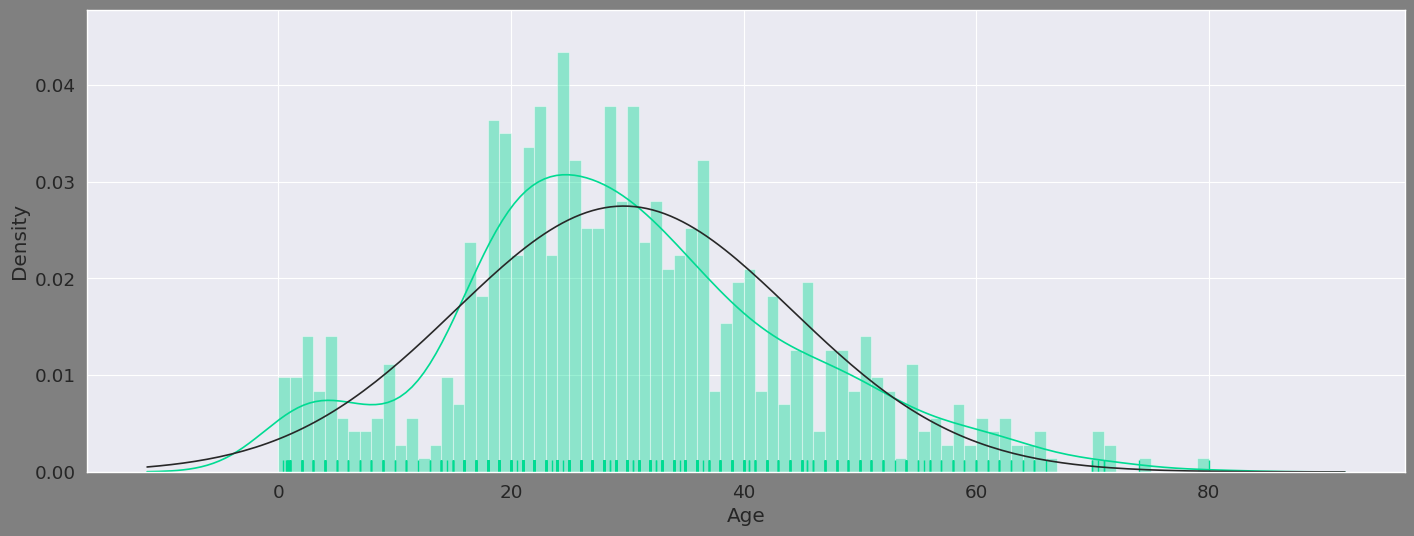

In [7]:
plt.figure(figsize = [17,6])
a = sns.distplot(traindf['Age'].dropna(),bins = range(0,81,1), rug = True, fit = norm)

What does the graph tell us? Most of the Passengers aboard the Titanic were in the range of 16~ to 40. The age distribution shows bi-modal curve.

<ipython-input-8-cf50d16d8e26>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traindf[traindf['Survived']==1]['Age'].dropna(),norm_hist = True,bins = np.arange(0,81,1),color = 'blue',
<ipython-input-8-cf50d16d8e26>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traindf[traindf['Survived']=

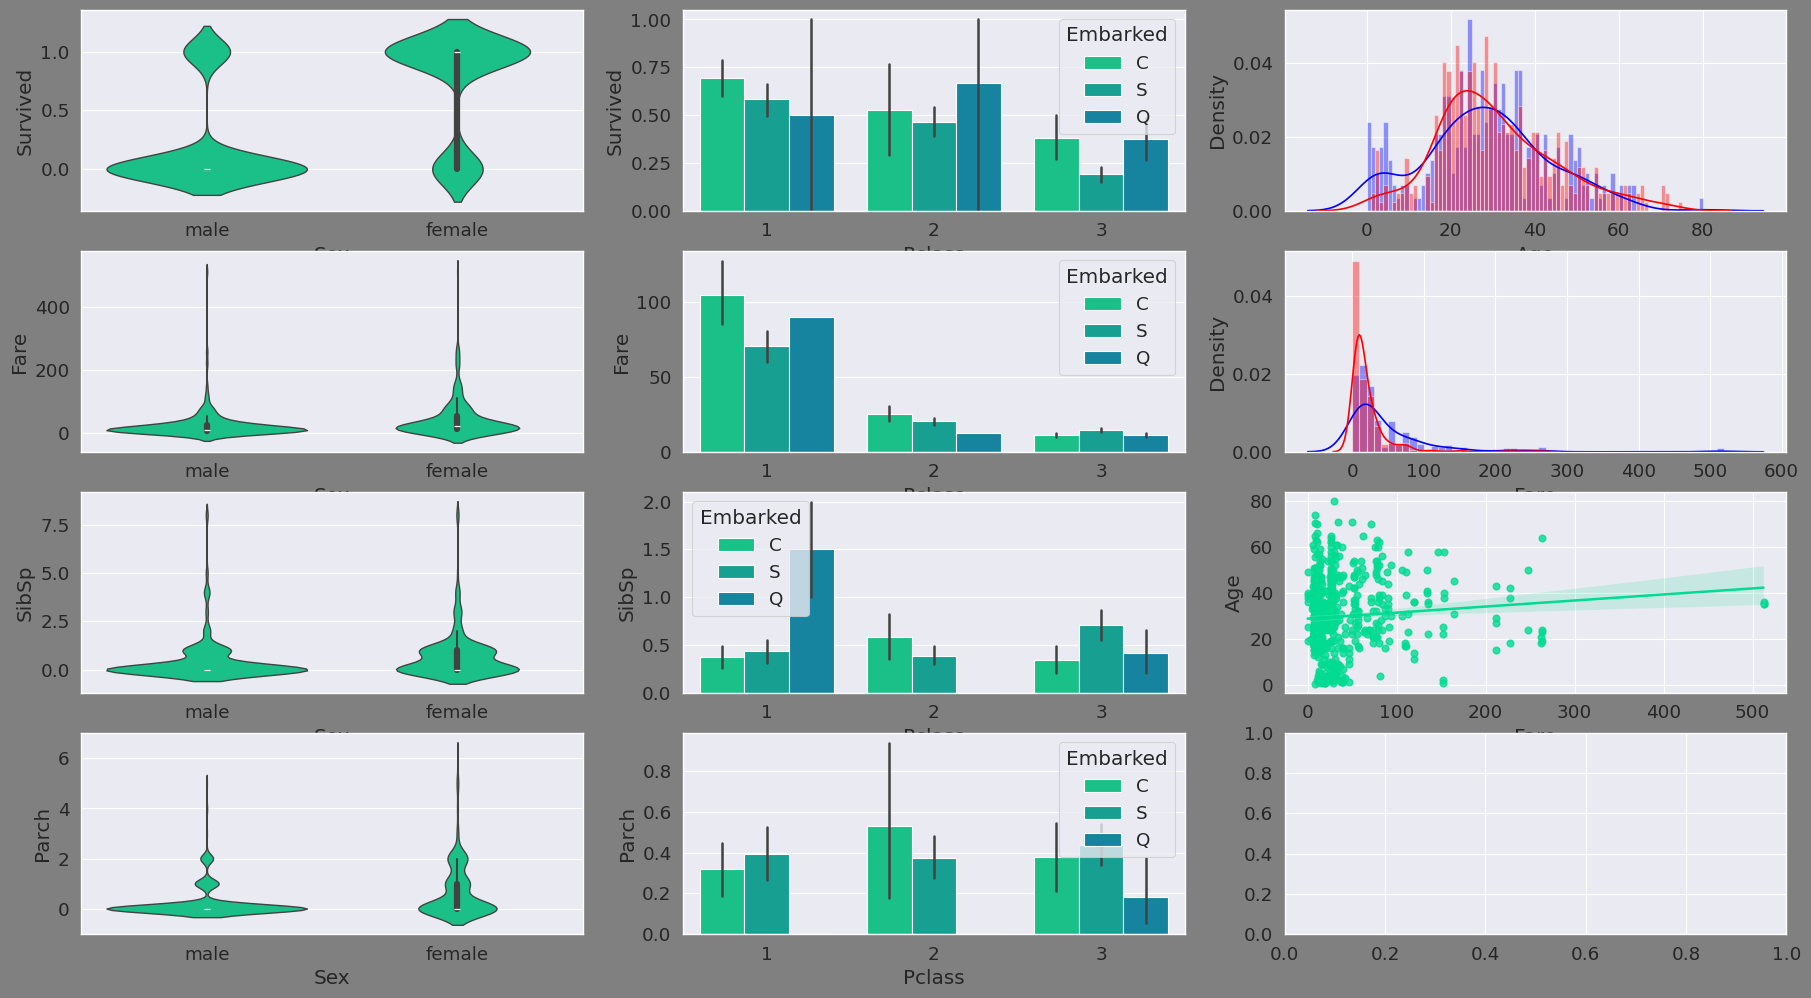

In [8]:
f, ax = plt.subplots(4, 3,figsize=[22,12])
#sns.set_palette('Set1', 8, .75)
#sns.set_style('whitegrid')
#plt.subplot(331)
sns.violinplot(x = 'Sex', y = 'Survived', data = traindf,ax = ax[0,0])
#sns.despine(offset=10, trim=True)
#plt.subplot(332)
sns.barplot(x = 'Pclass',y ='Survived',data = traindf,hue = 'Embarked',ax = ax[0,1])
#plt.subplot(333)
sns.distplot(traindf[traindf['Survived']==1]['Age'].dropna(),norm_hist = True,bins = np.arange(0,81,1),color = 'blue',
            ax = ax[0,2])
sns.distplot(traindf[traindf['Survived']==0]['Age'].dropna(),norm_hist = True,bins = np.arange(0,81,1), color = 'red',
            ax = ax[0,2])
#plt.subplot(334)
sns.violinplot(x = 'Sex', y = 'Fare', data = traindf,ax = ax[1,0])
#plt.subplot(335)
sns.barplot(x ='Pclass', y = 'Fare',data = traindf , hue = 'Embarked', ax = ax[1,1])
#plt.subplot(336)
sns.distplot(traindf[traindf['Survived']==1]['Fare'].dropna(),bins = np.arange(0,580,10),color = 'blue',
            ax = ax[1,2])
sns.distplot(traindf[traindf['Survived']==0]['Fare'].dropna(),bins = np.arange(0,580,10),color = 'red',
            ax = ax[1,2])

#plt.subplot(337)
sns.violinplot(x = 'Sex', y ='SibSp',data = traindf,ax = ax[2,0])
#plt.subplot(338)
sns.barplot(x= 'Pclass', y = 'SibSp', data = traindf, hue = 'Embarked', ax = ax[2,1])
#plt.subplot(339)
sns.regplot(x = 'Fare', y = 'Age', data = traindf, ax = ax[2,2])
#plt.subplot(341)
sns.violinplot(x = 'Sex', y = 'Parch', data = traindf, ax = ax[3,0])
#plt.subplot(342)
sns.barplot(x = 'Pclass', y = 'Parch', data = traindf, hue = 'Embarked', ax = ax[3,1])
plt.close(12)
plt.close(13)
plt.close(14)

**1.** Starting from the first graph, we can see that very few males survived as compared to female  and very few females died in comparision to males.

**2.** First and second class had the most survival rate than the third class whereas pessangers who boarded from *'S'* had the least survival rate.

**3.** The *blue* and *red* distribution shows whether the pessanger survived or not.

**4. & 5.** There were many passengers from both category who paid nothing to board the ship particularly from the **third** class

**6.** The distribution of Fare with respect to Survival *blue* indicating Survived while *red* indicating dead.

**7. & 8.** There were more *female* SibSp(siblings and spouces) as compared to *male* and majority of them were from **First** class from *Q* station followed by **third** class.

**9.** Distribution of Fare by Age shows that there were many passengers paying nothing being majority while a few paying more than 500!

**10. & 11.** By looking at the graph we can see that it is similar with SibSp to some extent with the only difference that *Parch* is flattened and the bar plot says that *Parch* there were no Passengers from *Q* aboard as *1st* and *2nd* class.



In [9]:
traindf[traindf['Fare']>500]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


We can see that those who paid highest have the same ticket names. we'll investigate this further.

In [10]:
def get_isnull(train,test):
    return(train.isnull().sum(), test.isnull().sum())

In [11]:
get_isnull(traindf,testdf)

(Survived      0
 Pclass        0
 Name          0
 Sex           0
 Age         177
 SibSp         0
 Parch         0
 Ticket        0
 Fare          0
 Cabin       687
 Embarked      2
 dtype: int64,
 Pclass        0
 Name          0
 Sex           0
 Age          86
 SibSp         0
 Parch         0
 Ticket        0
 Fare          1
 Cabin       327
 Embarked      0
 dtype: int64)

There are alot of missing values present in both the datasets which is not good for our model.

In [12]:
#function for concatation so that we won't have to repeat them again and again in future.
def combine(data1,data2):
    fulldf = pd.concat([data1,data2])
    return fulldf

In [13]:
#Function for separation so that we won't have to repeat them again.
def saperate(data):
    data1 = data.iloc[:len(traindf)]
    data2 = data.iloc[len(traindf):]
    return data1, data2

In [14]:
testdf[testdf['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


median is used instead of mean so that the value does not sway too much in a direction.

In [15]:
def filling(data1,data2):
    data = combine(data1,data2)
    data['Embarked'] = data['Embarked'].fillna('C')
    data['Age']      = data['Age'].fillna(data['Age'].median())
    data['Fare']     = data['Fare'].fillna(data['Fare'].median())
    data['Cabin']    = data['Cabin'].fillna('Z')
    data['Cabin']    = data['Cabin'].apply(lambda x: str(x)[0])
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = filling(traindf, testdf)
#testdf = filling(testdf)


<Axes: xlabel='Cabin', ylabel='Survived'>

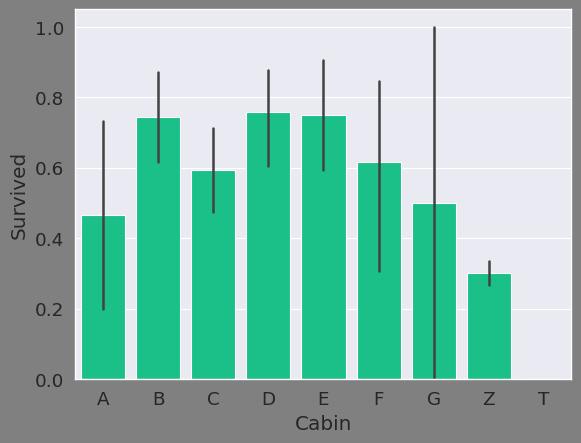

In [16]:
sns.barplot(x= 'Cabin', y = 'Survived', data = traindf ,order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Z', 'T'])

In [17]:
def pew(data1, data2):
    data = combine(data1,data2)
    data['Cabin'] = data['Cabin'].replace(['B', 'D', 'E'], 'H')   #High
    data['Cabin'] = data['Cabin'].replace(['F', 'C'], 'M')        #Medium
    data['Cabin'] = data['Cabin'].replace(['T', 'G', 'A',], 'L')  #Low
    data['Cabin'] = data['Cabin'].replace(['Z'],'X')              #Missing
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = pew(traindf,testdf)
#testdf  = pew(testdf)

It's better that we combine both SibSp and Parch as they can be represented as family.

In [18]:
def family(data1, data2):
    data = combine(data1,data2)
    data['Family'] = data['SibSp'] + data['Parch'] + 1
    data['Alone']  = data['Family'].apply(lambda x: 1 if x == 1 else 0)
    data.drop(['SibSp','Parch'],axis = 1, inplace = True)
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = family(traindf, testdf)
#testdf  = family(testdf)


AttributeError: module 'seaborn' has no attribute 'factorplot'

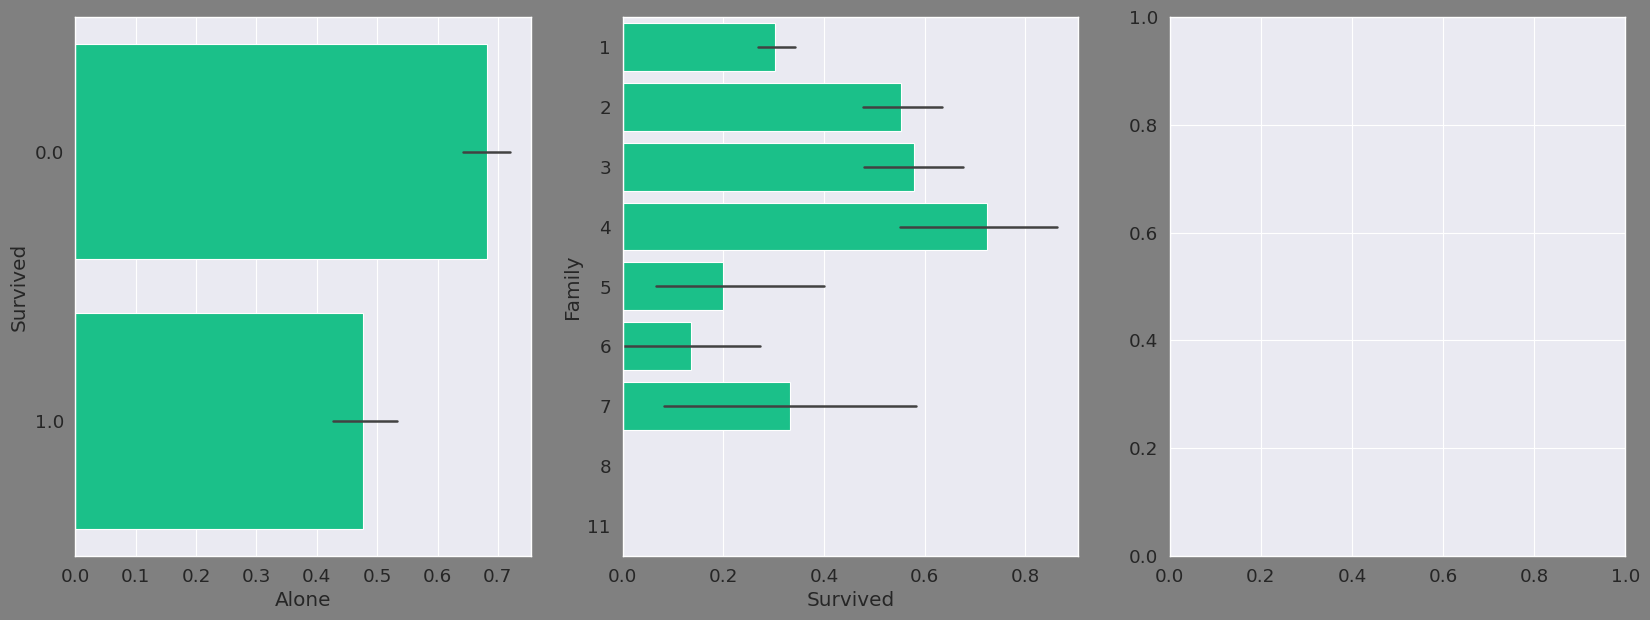

In [19]:
f,ax = plt.subplots(1,3,figsize=[20,7])
sns.barplot(x = 'Alone', y = 'Survived', data = traindf,orient = 'h', ax = ax[0])
sns.barplot(x = 'Survived', y = 'Family', data = traindf,orient = 'h', ax = ax[1])
sns.factorplot(y = 'Family',data = traindf, kind = 'count', orient = 'h', ax = ax[2])
plt.close(2)
plt.close(3)

Most of the Passengers aboard were alone. The Passengers who were alone had a lower survival rate which is also true for Passengers who had more than 4 members with them.

In [ ]:
traindf.head()

In [ ]:
def FamilyGroup(data1, data2):
    data = combine(data1,data2)
    data.loc[data['Family'] > 2, 'FamilyGroup'] = 3
    data.loc[data['Family'] == 1, 'FamilyGroup'] = 1
    data.loc[data['Family'] == 2, 'FamilyGroup'] = 2
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = FamilyGroup(traindf, testdf)
#testdf  = FamilyGroup(testdf)

In [ ]:
def mapping(data1, data2):
    data = combine(data1,data2)
    data['Embarked'] = data['Embarked'].map({'C':1, 'S':2, 'Q':3})
    data['Sex']      = data['Sex'].map({'male': 1,'female':0})
    data['CabinGroup'] = data['Cabin'].map({'H': 0, 'M': 1, 'L': 2, 'X':3})
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = mapping(traindf, testdf)
#testdf  = mapping(testdf)

In [ ]:
traindf['CabinGroup'].value_counts()

In [ ]:
traindf.head()

In [ ]:
def Titles(data1, data2):
    data = combine(data1,data2)
    data['Title'] = data['Name'].apply(lambda x: str(x).split(',')[1].split('.')[0])
    data['TitleGroup'] = 0
    data['TitleGroup'] = data['Title'].replace(['Mme','Ms','Lady','Sir','Mlle','the Countess',],0,          #High
                                            regex = True).replace(['Mrs','Miss','Master',],1,               #Medium
                                            regex = True).replace(['Dr','Major','Col','Mr'],2,              #Low
                                            regex = True).replace(['Don','Rev','Capt','Jonkheer','Dona'],4, #Least
                                            regex = True)
    #data['TitleGroup'] = data['TitleGroup'].replace({'male':1,'female':0,'Special':2})
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = Titles(traindf, testdf)
#testdf  = Titles(testdf)
##['Mrs','Miss','Mme','Ms','Lady','Mlle','Countess','Dona'],'female'
##['Sir','Don','Rev','Mr',],'male'
##['Col','Dr','Col','Capt','Major','Jonkheer','Master'],'Special'

In [ ]:
plt.figure(figsize = [8,5])
sns.barplot(x = 'Survived', y = 'Title', data = traindf, palette = 'Blues_d',)

In [ ]:
def surname(data1, data2):
    data = combine(data1,data2)
    data['Surname'] = data['Name'].apply(lambda x: str(x).split(' ')[0].split(',')[0])
    Shares = 0
    Shares = data.groupby('Surname').apply(lambda x: x.shape[0])
    data['SharedSurname'] = data['Surname'].map(Shares)
    traindf, testdf    = saperate(data)
    return traindf, testdf

traindf, testdf = surname(traindf, testdf)


In [ ]:
traindf.loc[traindf['Ticket'].str.contains('113803')]

In [ ]:
def age_distribution(data1, data2):
    data = combine(data1,data2)
    data.loc[data['Age']].round()
    data.loc[data['Age'] <= 16, 'AgeGroup'] = 1
    data.loc[(data['Age'] > 16) & (data['Age'] <= 40), 'AgeGroup'] = 2
    data.loc[(data['Age'] > 40) & (data['Age'] < 60), 'AgeGroup'] = 3
    data.loc[(data['Age'] >= 60), 'AgeGroup'] = 4
    #data['AgeGroup'].astype(int)
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = age_distribution(traindf, testdf)
#testdf = age_distribution(testdf)
plt.figure(figsize = [17,6])
sns.barplot(x = traindf['AgeGroup'], y = traindf['Survived'])#data = traindf,)#ci = 95, orient = 'v')
plt.rc('xtick',labelsize = 12)

In [ ]:
traindf.head(2)

In [ ]:
sns.factorplot(x = 'Pclass', y = 'Fare', col = 'Embarked', hue = 'Sex', data = traindf, margin_titles = True)

There is much difference for *1st* and *2nd* Embarkation for *1st* and *3rd* Pclass in terms of fare for males and females while the *2nd* class fare is similar in all the Embarkations.

In [ ]:
def SharedSurname(data1, data2):
    data = combine(data1,data2)
    Shares = 0
    Shares = data.groupby('Surname').apply(lambda x: x.shape[0])
    data['SharedSurname'] = data['Surname'].map(Shares)
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = SharedSurname(traindf, testdf)
#testdf  = SharedSurname(testdf)

In [ ]:
testdf.head(3)

Grouping Fare and creating a new column called *'FareGroup'* with their means by Pclass

In [ ]:
def fare_distribution(data1, data2):
    data = combine(data1,data2)
    payment = data.groupby('Pclass')['Fare'].mean()
    data.loc[(data['Fare'] < payment[3]),'FareGroup'] = 1
    data.loc[(data['Fare'] > payment[3]) & (data['Fare'] <  payment[2]),'FareGroup'] = 2
    data.loc[(data['Fare'] > payment[2]) & (data['Fare'] <  payment[1]), 'FareGroup'] = 3
    data.loc[(data['Fare'] > payment[1]),'FareGroup'] = 4
    #data['Fare'] = data['Fare'].map({'Very Low': 0, 'Low': 1, 'Medium':2, 'High':3})
    data['FareGroup'] = data['FareGroup'].astype(int)
    traindf, testdf    = saperate(data)
    return traindf, testdf
#payment = fulldf.groupby('Pclass')['Fare'].mean()
traindf, testdf = fare_distribution(traindf, testdf)
#testdf = fare_distribution(testdf)


In [ ]:
#pd.get_dummies(traindf,columns = (['Pclass','Sex','Age','Fare','Embarked','Family','Alone','Title']), drop_first = True)

In [ ]:
def Tickets(data1, data2):
    data = combine(data1,data2)
    #Creating a new column to display the freq of the tickets present
    data['SharedTicketCount'] = data.groupby('Ticket')[['Fare']].transform('count').astype(int)
    #Removing any characters other than alphabets and numbers to count the ticket length
    data['Ticket'] = data['Ticket'].str.replace('.','').str.replace('/','').str.replace(' ','')
    data['TicketLength'] = data['Ticket'].apply(lambda x: len(str(x)))
    traindf, testdf    = saperate(data)
    return traindf, testdf
traindf, testdf = Tickets(traindf, testdf)
#testdf = Tickets(testdf)

In [ ]:
traindf.columns

In [ ]:
traindf.head()

In [ ]:
X = traindf.drop(['Name','Title','Surname','Survived','Cabin','Ticket',
                  'Age','Fare','Family','Alone'],axis = 1)
y = traindf['Survived']
X.shape , y.shape

In [ ]:
X.columns

# Correlation

In [ ]:
f, ax = plt.subplots(figsize = [25,16])
sns.heatmap(traindf.corr(),linewidths = .5, annot = True, cmap = 'YlGnBu', square = True)

Since categorical features have been created from the features present in the dataset taking only the categorical for training the models.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance

In [ ]:
X.columns

In [ ]:
npX = np.array(X).copy()
npy = np.array(y).copy()

<h1><center>Models</center></h1>

In [ ]:
clf_rf = RandomForestClassifier()
clf_et = ExtraTreesClassifier()
clf_bc = BaggingClassifier()
clf_ada = AdaBoostClassifier()
clf_dt = DecisionTreeClassifier()
clf_xg = XGBClassifier()
clf_lr = LogisticRegression()
clf_svm = SVC()

In [ ]:
Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','LogisticRegression','SVM']
scores = []
models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_xg, clf_lr, clf_svm]
for model in models:
    score = cross_val_score(model, npX, npy, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    scores.append(score)

In [ ]:
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)

In [ ]:
mode

Selecting the top 3 classifiers for model prediction.

In [ ]:
parameters_xg = {'max_depth':[3,6,7], 'learning_rate': [0.1,0.2], 'n_estimators': [300,200],
                 'min_child_weight': [4], 'reg_alpha': [6,0], 'reg_lambda': [1,8],'max_delta_step':[2],
                 'gamma':[0],'seed':[1]}

parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0,0.1,'auto'], 'probability':[True,False],
                  'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}

parameters_rf = {'n_estimators': [100,50], 'max_features': [7,'auto',None],
                 'n_jobs': [-1], 'min_samples_leaf': [2,4,], 'random_state':[1,7,],
                 'min_samples_split':[2,6,], 'oob_score': [True,False],
                 'criterion': ['gini'], 'warm_start': [True,False]}


In [ ]:
def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 10,
                        scoring = 'accuracy')
    grid.fit(npX,npy)
    return grid.best_score_, grid.best_estimator_.get_params()

In [ ]:
def imp_features(model, model_name, params):
    Model = model(**params)
    Model.fit(npX,npy)
    names = X.columns
    feature = Model.feature_importances_
    important_features = pd.Series(data = feature, index = names,)
    important_features = important_features.sort_values(ascending = True)
    return important_features.plot(kind = 'barh', grid = False,title = model_name)

In [ ]:
best_score_xg, best_params_xg = grid(clf_xg,parameters_xg)
print(best_score_xg)
imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

In [ ]:
best_score_rf, best_params_rf = grid(clf_rf, parameters_rf)
print(best_score_rf)
imp_features(RandomForestClassifier,'Random Forest', best_params_rf)

In [ ]:
best_score_svm, best_params_svm = grid(clf_svm, parameters_svm)
print(best_score_svm)

Let us visualize the decision boundaries to see if our models are overfitting or not but the number of features in our data set are 7+ we'll have to reduce the dimensions to 2 to be able to visualize, in this notebook PCA is used for dimensionality reduction.

<h1><center>Decision Boundary Visualization</center></h1>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
x = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)
X_train_reduced = PCA(n_components = 2).fit_transform(X_train)
X_test_reduced  = PCA(n_components=  2).fit_transform(X_test)

In [ ]:
def boundaries(model, heading, best_params):
    Model = model(**best_params)
    Model.fit(X_train_reduced, y_train)

    X_set, y_set = np.concatenate([X_train_reduced, X_test_reduced], axis = 0), np.concatenate([y_train, y_test], axis = 0)
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                             np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

    #plt.figure(figsize = [15,16])
    plt.contourf(X1, X2, Model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                     alpha = 0.5, cmap = ListedColormap(('k', 'blue')))

    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
    plt.xticks(fontsize = 3)
    plt.yticks(fontsize = 3)

In [ ]:
fig = plt.figure(figsize=[15,7])

ax = plt.subplot(1,2,1)
plt.title('XGBClassifier')
boundaries(XGBClassifier,'eXtreme Boosting Classifier', best_params_xg)


ax = plt.subplot(1,2,2)
plt.title('RandomForest')
boundaries(RandomForestClassifier, 'Random Forest', best_params_rf)

The graphs above clearly shows that the models are overfitting quite a bit, hence their performance will be bad on the test set. Let's look at our SVM model's decision boundaries with **mlxtend** library.

In [ ]:
from mlxtend.plotting import plot_decision_regions
t = np.array(y_train)
t = t.astype(np.integer)
clf_svm = SVC(**best_params_svm)
clf_svm.fit(X_train_reduced,t)
plt.figure(figsize = [15,10])
plot_decision_regions(X_train_reduced, t, clf = clf_svm, hide_spines = False, colors = 'purple,limegreen',
                      markers = ['^','v'])
plt.title('Support Vector Machines')

In [ ]:
clf_svm = SVC(**best_params_svm)
clf_svm.fit(npX,npy)
testdf = testdf.drop(['Name','Title','Surname','Survived','Cabin','Ticket',
                  'Age','Fare','Family','Alone'],axis = 1)
nptest = np.array(testdf)
pred = clf_svm.predict(nptest)
predictions = pd.DataFrame(pred, index = testdf.index, columns = ['Survived'])
predictions.to_csv('predictions_svm_with_groups.csv')

![](http://i.imgur.com/LyRLYuc.png)

<h1><center> References </center></h1>

* Titanic Data Processing with Python: [Jarvis Yang](https://www.kaggle.com/chuanguy/titanic-data-processing-with-python-0-813)
* mlxtend library: [Eike Dehling](https://www.kaggle.com/eikedehling)
* Decision Boundary from scratch: [bronson](https://www.kaggle.com/jsultan/visualizing-classifier-boundaries-using-kernel-pca)
* And to everyone on the discussion forums for solving my doubts.